In [26]:
library("car")
library("DAAG")
library("leaps")
library("psych")

# Analysis of the Bananas

* Quality Score: A numerical score, likely on a scale of 1-4 that rates the overall quality of the banana sample
* Ripeness: How ripeness the banana is.
* Sugar Content Brix: Amount of sugar measured in degrees Brix.
* Firmness (kgf): It's associated with the texture of the banana (hard or soft).
* Length (cm): How long the banana is.
* Tree age: The age of the banana tree.
* Altitude: It's the altitude at which bananas plants are growing, measured in meter above the sea. There are bananas that grow better in a certain altitude and conditions that others.
* Rainfall (mm): Amount of rainfall in the zone where the bananas were harvested. A higher amount of rainfall may indicate favorable growing conditions for bananas.
* Soil nitrogen: Measured in part per million (ppm). It's the concentration of nitrogen in the soil where the bananas were harvested. This variable is a crucial nutrient for plant growth.


In [27]:
# Load the data
bananas <- read.csv("../data/banana.csv")

The goal of this analysis is to identify which variables are important at the time to determine the quality of a banana. And then build a regression model to predict the quality of an unseen record. 

In [28]:
# Filter those variables that are not numeric to build the feature's matrix.
numeric_cols <- c()
for (i in 1:ncol(bananas)){
    if (class(bananas[, i]) == "numeric"){
        numeric_cols <- c(numeric_cols, i)
    }
}
bananas_num <- bananas[, numeric_cols]
# Build a regression model by setting the quality_score as the target and the rest as explained variables. 
model <- lm(quality_score~., data = bananas_num)
model


Call:
lm(formula = quality_score ~ ., data = bananas_num)

Coefficients:
       (Intercept)      ripeness_index  sugar_content_brix        firmness_kgf  
        -1.997e+00           2.002e-01           1.565e-01          -1.565e-02  
         length_cm            weight_g      tree_age_years          altitude_m  
         3.975e-02           3.207e-05           2.286e-04           3.833e-06  
       rainfall_mm   soil_nitrogen_ppm  
         1.692e-06          -6.756e-05  


In this case we consider the rest as predicted variables, but this lead that the regression model is not good to predict the quality score of a banana. Therefore, it will be explained how to know when a model is good or not and how to improve it. 

In [29]:
# Analyse the domain of the target variable
summary(bananas_num$quality_score)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.920   2.090   2.440   2.465   2.850   3.890 

In [30]:
# Another form to calculate the coefficientes of the model by using the canonical equation of regression 
Y <- bananas_num[, "quality_score"] # Dependent or target variable
X <- bananas_num[, -1] # Exclude the target variable
ones_col <- matrix(rep(1, nrow(bananas_num)), nrow = nrow(bananas_num))
# Add a column with ones
X <- as.matrix(cbind(ones_col, X)) # Reserved for intercept (\beta0)
# Get the coefficients vector
betas <- solve(t(X) %*% X) %*% t(X) %*% Y
# Now, we can compute the fitted values for each observation.
y_hat <- X %*% betas
# To understand the content of y_hat
cat("The expected quality score for the banana associated with observation 1:", y_hat[1])

The expected quality score for the banana associated with observation 1: 1.85639

In [31]:
# Calculate the mean of the residuals or errors that our model committed.
# If it's accuracy, the residuals have to be close to 0.
SSR <- sum((Y - y_hat)^2)
# To calculte the mean of the sum of squares it's important to know the number of
# degrees of freedom that we have now (n-10), because we have estimated 10 betas.
n <- nrow(bananas_num) - 10
MSSR <- 1/n * SSR
MSSR

[1] 0.004727049

Despite the fact that we have choosen all the numeric variables to build the model, the variance estimated of the residuals is very close zero.
$$
Var^{\hat{}}(e)=MSSR = 4.72 \cdot 10^{-3} 
$$

In [32]:
# To do the same process by using the model object
MSSR <- sum(model$residuals^2) / model$df.residual
Y_hat <- model$fitted.values # Fitted values calculated by the model

Another important result that it can be computed by using the expression that we have used to calculate the coefficients vector:
$$
Y^{\hat{}} = X\beta^{\hat{}} = X(X^tX)^{-1}X^tY = HY;\quad H =  X(X^tX)^{-1}X^t
$$
The famuous Hat matrix. This stores the leverages ($h$) of each observation along its diagonal. These leverage values measure how far an observation is from the "center" of the predictor variable space, considering the multivariate relationships between variables.

A high leverage value indicates that the observation has a greater potential to influence the estimation of the regression coefficients. This might lead to a hyperplane that poorly represents the overall data structure.

In [33]:
H <- X %*% solve(t(X) %*% X) %*% t(X)
leverages <- diag(H)

A leverage $h_{ii}$ is considered influential if it's greater than twice average leverage.
$$
h_{ii} \text{ is influential } \iff h_{ii} > 2(\frac{1}{n}\Sigma_{i=1}^n h_{ii})
$$
And there is a property that sets that the total sum of the leverages is equal to the number of coefficientes that we've estimated, that means $\Sigma_{i=1}^n h_{ii} = k + 1$.

$$
h_{ii} \text{ is influential } \iff h_{ii} > 2(\frac{\rho}{n});\quad \rho = k + 1
$$


In [104]:
p <- model$rank # Number of estimated coefficientes for the model 
n <- nrow(bananas_num) # Numbe of observations
# To search for the influential points
influential_points <- which(leverages > (2 * p/n))
if (sum(influential_points) == 0){
    print("There are not influential points")
}else{
    cat("Influential points", influential_points)
}

[1] "There are not influential points"


In [35]:
# Print the summary of the coefficients of the model
summ_model1 <- summary(model)
summ_model1


Call:
lm(formula = quality_score ~ ., data = bananas_num)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.217729 -0.055512  0.001806  0.052638  0.146401 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -1.997e+00  2.610e-02 -76.504   <2e-16 ***
ripeness_index      2.002e-01  1.248e-03 160.408   <2e-16 ***
sugar_content_brix  1.565e-01  1.072e-03 146.038   <2e-16 ***
firmness_kgf       -1.565e-02  1.692e-03  -9.252   <2e-16 ***
length_cm           3.975e-02  3.806e-04 104.441   <2e-16 ***
weight_g            3.207e-05  4.440e-05   0.722   0.4704    
tree_age_years      2.286e-04  4.181e-04   0.547   0.5846    
altitude_m          3.833e-06  5.113e-06   0.750   0.4536    
rainfall_mm         1.692e-06  3.864e-06   0.438   0.6614    
soil_nitrogen_ppm  -6.756e-05  4.068e-05  -1.661   0.0971 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06875 on 990 degrees of freedom
Mul

Understanding this table is really important to know, because you can see which independent variables are necessary to use in the model, the mean error that it commits at the time to get the fitted values and the predictive capacity of the model. So I will explain it in detail:

* Residuals's section: How the errors or residuals that the model committed to compute the fitted values vary. As we can see there is a banana whose estimated quality rate is greater than the real by 0.21 units. Remind that an residual is $e_i = y_i - y_i^{\text{hat}}$. It's important that the residuals are close to 0, since it's a indicator that the estimated values are close of real ones.
* Coefficients's section:
  * Esimate: Estimated value of the coefficient of an explanatory variable ($X_i$). It is the average effect on $Y$ (target) of a one unit increase in $X_i$, holding all other predictors fixed. All of these coefficients are calculated by using the OLS (Ordinary Least of Squares), that means minimizing SSR:
    $$
    SS(R) = \Sigma_{i=1}^n (y_i - y_i^{\text{hat}}) = \Sigma_{i=1}^n e^2; \quad y_i^{\text{hat}} = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_kX_k  
    $$
  * Std. Error: The error committed when calculating the estimator.
    
  To understand the two last columns it's important to know what hypothesis contrast is being used here:
  $$
  \begin{cases}H_0:\beta_i = 0\\H_1:\beta_i \ne 0\end{cases}
  $$
  This means if the independent variable $X_i$ is significant to explain the variability of the quality rate ($Y$). So we have to standardize the estimator $\beta_i^{\text{hat}}$ in the scenario where the $H_0$ is true:
  $$
  \beta_i^{ \text{hat} } \in N(\beta_i, S_{\beta_i^{\text{hat}}}) \rightarrow t = \frac{ \beta_i^{ \text{hat} } - \beta_i}{S_{\beta_i^{\text{hat}}}} = \frac{ \beta_i^{ \text{hat} }}{S_{\beta_i^{\text{hat}}}}
  $$

  Then the third column is calculated as the division of the first and second one: $t=\frac{\text{Estimate}}{\text{Std. Error}}$. Finally, this value is used to compute the $p$-value to know whether it's a significant hypothesis contrast (i.e. accept $H_1$) .
  $$
  p\text{-value} < [0.01, 0.05, 0.1]  \rightarrow \text{Accept }H_1 \rightarrow \text{This variable is significant at the time to explain the variability of } Y
  $$
  And as we can see, we only get significant values for the variables: ripeness_index, sugar_content_brix, firmness_kgf, length_cm and even soil_nitrogen_ppm if it considered a significance level of $\alpha = 0.1$.

*  Bottom's section:
    * Residual standard error (RSE): It is the average amount that the response will deviate from the true regression plane.
$$
\text{RSE} = \sqrt{MSSR}
$$
    * Multiple R-squared ($R^2$): It measures the predictive capability of the model, since it represents the percentage of total variance that is explained for the model:
  $$
  R^2 = \frac{SS(E)}{SS(G)}:\quad E \rightarrow \text{Explained};G \rightarrow \text{Global}
  $$
  However, this statistic increases artifically when more explanatory variables are included in the model, so in this case it's better to use the $\text{adjust}-R^2$. In our model, they don't vary a lot (0.984 $\approx$ 0.9838) and the proportion obtained is very high, so we can use it to predict a quality score of a banana.

    * F-statistic: It computes the proportion between the variability explained and unexplained by the model.
        $$
          F^{\hat{}} = \frac{MSS(E)}{MSS(R)}
        $$
      If it has a significant $p$-value (i.e. close to 0), that means that at least one of the explanatory variables is useful or is related to the dependent variable. The hypothetical contrast is as follos:
    $$
    \begin{cases}H_0: \beta_1 = \beta_2 = ... = \beta_n = 0 \\ H_1: \text{At least one of them is not zero}\end{cases}
    $$
    As you can see, the $p$-values is $\approx$ 0, so we know at least one of the 9 variables that were included is significant to explain the variability of the quality score.

---

At this point, we know the variables 'weight_g', 'tree_age_years', 'altitude_m' and 'rainfall_mm' don't be need to be included in the regression model due to the large $p$-value associated with them, meaning that they have no influence over the quality score of a banana. This is a good way to reduce the complexity of our model:


In [36]:
# Remove the variables with no influence:
# update(model, response~explanatories) | .~(The response variables remains unchanged)
model2 <- update(model, .~.-weight_g-tree_age_years-altitude_m-rainfall_mm)
summ_model2 <- summary(model2)

If we compare the statistics of the two models:
* $R^2$ is greater when it includes more variables. Therefore, we need to check the $R^2_{\text{adjust}}$.

In [37]:
(summ_model1$r.squared > summ_model2$r.squared) && (summ_model1$adj.r.squared < summ_model2$adj.r.squared)

[1] TRUE

* Analyze whether the RSE (Residual Standard Error) has decreased for the updated model. 

In [38]:
rse_m1 <- summ_model1$sigma; rse_m2 <- summ_model2$sigma
pct <- (1 - rse_m2 / rse_m1)*100
cat("RSE has decreased in", pct, "%")

RSE has decreased in 0.122226 %

In [39]:
anova(model2, model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,994,4.687208,NA,NA,NA,NA
2,990,4.679778,4,0.007429179,0.3929079,0.8138208


You can use ANOVA (Analysis of Variance) to compare two nested models and check which one is better. In this case, we got a $p$-value $=.81$, which tell us to choose the model without the variabales that are not related to quality_score (i.e $H_0$):
$$
\begin{cases}H_0 = m(X) = \beta_0 + \beta_1\cdot\text{ripeness}+ \beta_2\cdot\text{sugar}+\beta_3\cdot\text{firmness}+\beta_4\cdot\text{length}+\beta_5\cdot\text{soil} \\ H_1 = m(X) = \beta_0 + \beta_1\cdot\text{ripeness}+ \beta_2\cdot\text{sugar}+\beta_3\cdot\text{firmness}+...+\beta_9\cdot\text{soil}\end{cases}
$$

Now, our model is composed of the features that need to be taken into account to measure the expected quality score of a banana. However, it's important to check that the explanatory variables are not correlated among them, since it could affect their true influence into the response. We have many tools to check this:

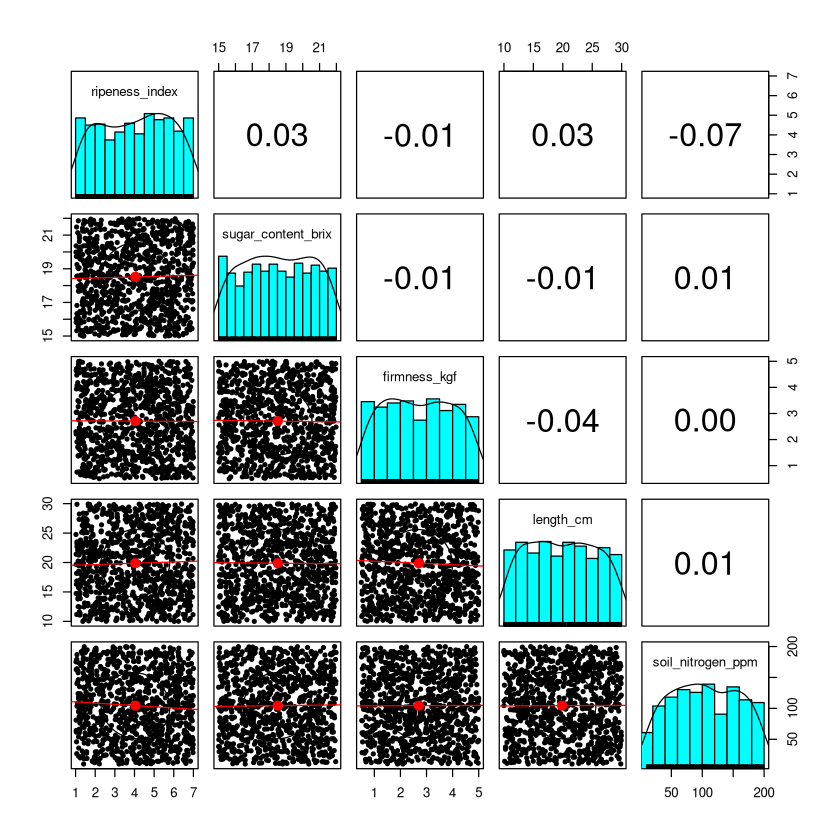

In [40]:
# Build the matrix of features
X <- bananas_num[, c("ripeness_index", "sugar_content_brix", "firmness_kgf", "length_cm", "soil_nitrogen_ppm")] 
# 1) Correlation Matrix
pairs.panels(X, smooth = TRUE, density=TRUE, digits = 2, 
             ellipses=TRUE, method="pearson", pch = 20, 
             lm=TRUE, cor=TRUE)

In [41]:
# 2) Calculating the partial correlations. This statistic computes the true influence of a predictor variable
#    on the reponse (i.e. quality score) by removing the effect of the other ones.
partial.r(X)

,ripeness_index,sugar_content_brix,firmness_kgf,length_cm,soil_nitrogen_ppm
ripeness_index,1.000000000,0.02850188,-0.003686374,0.033340971,-0.066000956
sugar_content_brix,0.028501879,1.00000000,-0.013938619,-0.010555682,0.015088912
firmness_kgf,-0.003686374,-0.01393862,1.000000000,-0.044792350,0.004627344
length_cm,0.033340971,-0.01055568,-0.044792350,1.000000000,0.007673615
soil_nitrogen_ppm,-0.066000956,0.01508891,0.004627344,0.007673615,1.000000000


As we can see, the partial correlations are similar to the bivariate. For example:
$$
X_1:\text{ Ripeness index};\quad X_2:\text{ Sugar Content Brix}
$$
$$
r_{X_1X_2, X_{-1, -2}}^2 = 0.028 \approx 0.03
$$
This is the true influence of $X_1$ on $X_2$ if we don't take into account the other 3 explanatory variables. Since there is no change with respect to bivarite correlation, this means that these variables don't alter its relationship.

In [42]:
# 3) Calculate the VIF (Variance Inflation Factor) of each predictor variable. This statistic consist of measures
#    how a explanatory variables is correlated with the other ones. If this amount is > 5 or 10, that means multicolinearity.
t(vif(model2))

ripeness_index,sugar_content_brix,firmness_kgf,length_cm,soil_nitrogen_ppm
1.0062,1.0013,1.0022,1.0032,1.0046


$$
\text{VIF} = \frac{1}{1 - R^2_{X_j }}
$$

* $R^2_{X_j}$: It represents the coefficient of determination when the predictive variable $X_j$ is considered the response and the others remain as the explanatory variables:
  $$
  X_j = X_{(-j)}\beta_{(-j)} + \epsilon
  $$
  If this statistic is high, it means the rest of the variables are able to predict the behavior of $X_j$, so it's not necessary to include it, because it would be redundant. And in such cases a high VIF is obtained.

As you can see through these three methods, the explanatory variables of our model are not correlated, so their influence on response is not biased.

---

As we mentioned earlier, if a point is associated with a high leverage, it has a high probability of being an influence point to estimate the least squares coefficients, but to check if this is true, you can use the following statistics:
1. Cook's distance: It measures how change the predicted values when the observation $i$-th is omitted. In this way, you can know which of them is influential.
   $$
   D_i = \frac{(Y^{\hat{}}- Y^{\hat{}}_{(i)})}{(k+1)\sigma^{2\hat{}}}
   $$
   * $Y^{\hat{}}_{(i)}\rightarrow$ Fitted values calculated by a model that did not include the observation $i$-th in its training set.
   To know how influential a Cook's distance could be:
    $$
D_i \text{ is influential} \iff D_i \geq F_{k+1, n-(k+1), \alpha}
$$

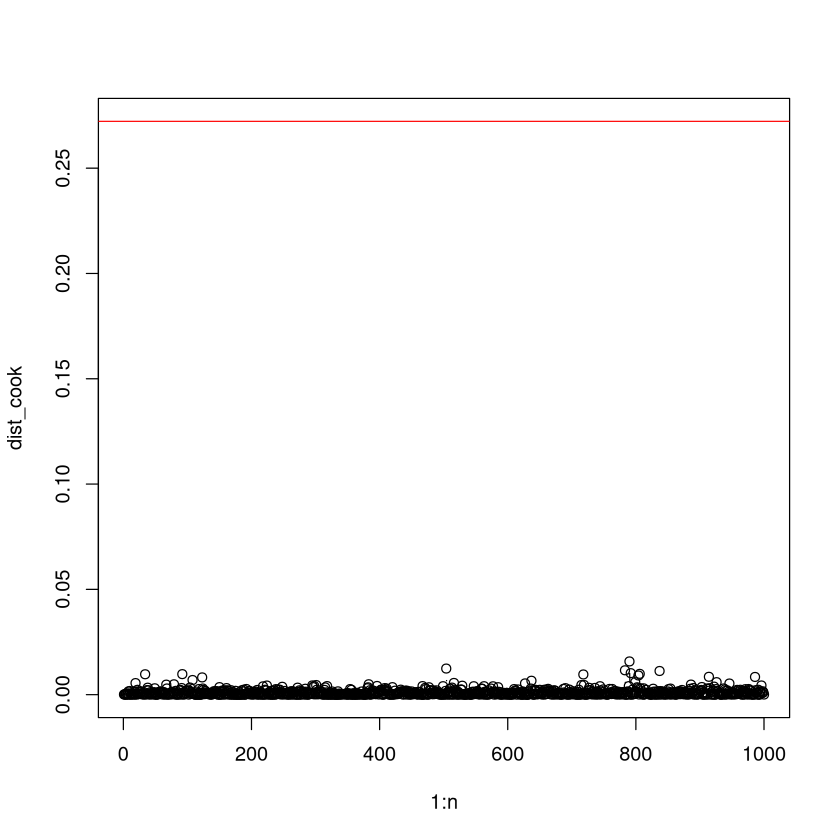

In [43]:
dist_cook <- cooks.distance(model2)
# Set a threshold with a significance level of 0.05
alpha <- 0.05
p <- length(model2$coefficients); n <- nrow(bananas_num)
threshold <- qf(alpha, p, n - p)
# Plot the Cook's distance
plot(1:n, dist_cook, type="b", ylim=c(0, threshold))
abline(h=threshold, col="red")

In [44]:
# Analytical way
which(dist_cook >= threshold)

named integer(0)

As you can see, no observation is greater than the threshold. So, we should not worry about the existence of a data point that affects the estimation of the coefficients of the model. Also, there are two more statistics that you can use to check which observations bias the least squares coefficients, and to see which predictor values change significantly when a model is trained on a dataset that does not include them:
* $\text{DFFIT}$: It measures how a predictor value of an observation changes in a model that does not include it in its training set.
  $$
  |\text{DFFIT}_i| > \frac{2}{\sqrt{\frac{k+1}{n}}} \rightarrow x_i \text{ is influential.} 
  $$ 
* $\text{DFBETA}$: It computes how the least squares coefficients change when the $i$-th observation is omitted.
  $$
  |\text{DFBETA}_i| > \frac{2}{\sqrt{n}} \rightarrow x_1 \text{ is influential.}
  $$

In [45]:
k <- length(model2$coefficients) - 1 #Without \beta0
n <- nrow(bananas_num)
# Set the thresholds
th_dffit <- 2 / sqrt((k+1)/n); th_dfbeta <- 2 / sqrt(n)

In [46]:
# In dfbetas, we need to check each row and see if some regression coefficient 
# change significantly
df_beta_infl <- apply(dfbeta(model2), MARGIN = 1, FUN = function(row) any(abs(row) > th_dfbeta))
which(df_beta_infl)

named integer(0)

In [47]:
which(abs(dffits(model2)) > th_dffit)

named integer(0)

Conclusion: No influential observations in the training set.

---

We have learned about statistics like $R^2$ and $\text{SS(R)}$, which are excellent tools to know if our model has a good performance at the training stage, by calculating the proportion of variance that is able to explain the explanatory variables that we have included over the response and how far the predictor values are with respect to the real ones. However, as we mentioned before, these statistics increase and decrease artificially, respectively when there are a high number of explanatory variables. And the idea is to get a model that is not too complex (parsimony) and good goodness of fit. So, now it's time to meet them...
* AIC (Akaike Information Criterion): It penalizes those models with a high number of explanatory variables to avoid always choosing the most complex, but rather one that has a good trade-off of goodness fit and complexity.
  $$
  \text{AIC} =2k -2\log({L(\beta)})
  $$
* BIC (Bayersian Information Criterion): It is similar to the one above, but this statistic penalizes the complex models more.
  $$
  \text{BIC} = k\log(n) - 2\log(L(\beta))
  $$
* Mallow's $C_p$:
  $$
  C_p = \frac{1}{n}(SS(R) +2k\sigma^{\hat{}2})
  $$
  A model is better than other one, if and only if its $C_p \approx k$, meaning this statistic has to be close to the number of explanatory variables used in the model.

In [48]:
# If we compare the models that we have created:
cp_mallow <- function(model){
    n <- length(model$fitted.values)
    k <- length(model$coefficients) - 1
    SSR <- sum(model$residuals^2) 
    MSSR <- SSR / (n-k-1) 
    cp <-(SSR/MSSR) - n - 2*(k+1)
    return(cp)
}
# Build table
table <- c()
functions <- c(AIC, BIC, cp_mallow)
table <- data.frame(matrix(c( sapply( functions, function(f) f(model)),
                              sapply( functions, function(f) f(model2))), 
                              ncol=3, byrow=TRUE))
colnames(table) <- c("AIC", "BIC", "CP"); row.names(table) <- c("Model1", "Model2")
table["k"] <- c(9, 5) # Predictor variables
table

,AIC,BIC,CP,k
,<dbl>,<dbl>,<dbl>,<dbl>
Model1,-2504.627,-2450.642,-30,9
Model2,-2511.041,-2476.687,-18,5


The model with less predictor variable is one that has a smaller AIC, BIC and a Mallow's CP more close to $k+1$ than the othe full model (Model1). These statistics tell us to choose the second one as our model.

---

Another form that you can use to find the best subset of explanatory variables according to the values of the variables that we presented above is the exhaustive search. We designed a function in the script 'linear_regression.R' that returns a table with contains the summary of this process.

In [108]:
source("../scripts/linear_regression.R")

In [77]:
# We need to pass a matrix that includes the features and reponse variable
models_table <- search_best_model(dataset = bananas_num, response_idx = 1)
models_table

,SS(R),R^2,R^2_adj,AIC,BIC,Cp,Modelo
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,157.223307,0.4620978,0.4615588,993.78892,-606.263,32264.351236,quality_score~ripeness_index
2,57.369017,0.8037255,0.8033318,-12.37383,-1607.518,11142.328141,quality_score~ripeness_index+sugar_content_brix
3,5.105478,0.9825328,0.9824802,-2429.56421,-4019.801,88.056010,quality_score~ripeness_index+sugar_content_brix+length_cm
4,4.700051,0.9839199,0.9838552,-2510.30491,-4095.634,4.288577,quality_score~ripeness_index+sugar_content_brix+firmness_kgf+length_cm
5,4.687208,0.9839638,0.9838832,-2511.04120,-4091.462,3.571632,quality_score~ripeness_index+sugar_content_brix+firmness_kgf+length_cm+soil_nitrogen_ppm
6,4.684507,0.9839731,0.9838762,-2509.61755,-4085.131,5.000309,quality_score~ripeness_index+sugar_content_brix+firmness_kgf+length_cm+altitude_m+soil_nitrogen_ppm
7,4.682105,0.9839813,0.9838683,-2508.13051,-4078.736,6.492091,quality_score~ripeness_index+sugar_content_brix+firmness_kgf+length_cm+weight_g+altitude_m+soil_nitrogen_ppm
8,4.680685,0.9839861,0.9838569,-2506.43364,-4072.131,8.191885,quality_score~ripeness_index+sugar_content_brix+firmness_kgf+length_cm+weight_g+tree_age_years+altitude_m+soil_nitrogen_ppm


In [79]:
# Get the model with 5 explanatory variables
model_5 <- models_table[length(model2$coefficients)-1, ]
model_5[, "Modelo"]

[1] "quality_score~ripeness_index+sugar_content_brix+firmness_kgf+length_cm+soil_nitrogen_ppm"

Let's check if the model that we have created with 5 explanatory variables is the same than the exhaustive method has computed.

In [95]:
coef <- names(model2$coefficients)[-1]
my_model <- "quality_score~"
for (i in 1:length(coef)){
    my_model <- paste0(my_model, coef[i], "+")
}
my_model <- substring(my_model, 1, nchar(my_model) - 1)
# Let's check
if (my_model == model_5["Modelo"]) print("They are the same.")
model_5[, -7]

[1] "They are the same."


,SS(R),R^2,R^2_adj,AIC,BIC,Cp
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,4.687208,0.9839638,0.9838832,-2511.041,-4091.462,3.571632


And if we compare this model with one tha includes 4 explanatory variables:

In [101]:
m4_m5 <- models_table[4:5, -7]
m4_m5 <- rbind(m4_m5, m4_m5[1, ] - m4_m5[2, ])
row.names(m4_m5) <- c(4, 5, "Difference")
m4_m5

,SS(R),R^2,R^2_adj,AIC,BIC,Cp
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,4.70005073,9.839199e-01,9.838552e-01,-2510.304909,-4095.633609,4.288577
5,4.68720760,9.839638e-01,9.838832e-01,-2511.041201,-4091.462146,3.571632
Difference,0.01284313,-4.393972e-05,-2.791855e-05,0.736292,-4.171463,0.716945


Our model has a better goodness, but these differences are not significant. You could choose to take the model with 4 explanatory variables if you want to sacrifice some goodness to reduce the complexity.

---

On the other hand, we have implemented a function that perform an influencial analysis about our model. It returns which observations has a high leverage, dffit, dfbeta and Cook's distance. 

In [102]:
influential_analysis(model = model2, alpha = 0.05) 

Observations with high leverage : 284 
Observations with high DFFIT :  
Observations with high DFBETA:  
Observations with high Cook's Distance :  


In contrast to model that include all the features, there is an observation with a high leverage. But remind that it is not necessary an influential point. Therefore, there are no observations with a high Cook's distance.

---

Finally, we can check if our model fulfills the regression hypotheses.

In [109]:
diag_model(model2)

Normal hipothesis
Lillie: 0.0001015651 
Shapiro 3.417907e-08 

Homocedasticity hipothesis
Breusch-Pagan: 1.535476e-07 

Randomness hypothesis
Ljung-Box: 0.7013832

* Linearity: We can see from the scatterplot, that the residuals vary randomly and are close to zero.
* Normal hipothesis: The null hyphotesis is denied. The residuals are not normal.
* Homocedasticity: The null hyphotesis is denied. There is no homocedasticity
* Randomness: The null hypothesis is denied. The residuals are not independent.

If these regression hypotheses are not fulfilled, then the result of our model are not valid. 

---

That is not the correct way to build a regression model as we mentioned at the beginning. But you need to take into account all these considerations and the most important thing is that the regression hypotheses are met.  